# Import Data and Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

import datetime
import math
import calendar

# Thanks for providing this in the forum
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [2]:
train = pd.read_csv('rossmann-store-sales/train.csv')
test = pd.read_csv('rossmann-store-sales/test.csv')
store = pd.read_csv('rossmann-store-sales/store.csv')


In [3]:
train.Store.nunique() == store.Store.nunique()

True

In [4]:
# Merge store data into training df
df = train.merge(store, how='left', left_on=train.Store, right_on=store.Store)
df.drop(['key_0', 'Store_y'], axis=1, inplace=True)
df = df.rename(columns={'Store_x':'Store'})
df.shape

(1017209, 18)

In [5]:
# store data do not have the same unique store counting as testing data.
test.Store.nunique() == store.Store.nunique()

False

In [6]:
df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [7]:
train.shape, test.shape, store.shape, df.shape

((1017209, 9), (41088, 8), (1115, 10), (1017209, 18))

In [8]:
round(df.describe().T,2)
# Gaussian distribution not satisfied: Sales, customers

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.43,321.91,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,4.00,2.00,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.82,3849.93,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.15,464.41,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.83,0.38,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.38,0.49,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.18,0.38,0.0,0.0,0.0,0.0,1.0
CompetitionDistance,1014567.0,5430.09,7715.32,20.0,710.0,2330.0,6890.0,75860.0
CompetitionOpenSinceMonth,693861.0,7.22,3.21,1.0,4.0,8.0,10.0,12.0
CompetitionOpenSinceYear,693861.0,2008.69,5.99,1900.0,2006.0,2010.0,2013.0,2015.0


In [9]:
# Check for duplicate
df.duplicated().sum(),test.duplicated().sum()

(0, 0)

In [10]:
# Check for missing value
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 11)

# EDA

In [11]:
df.Date = pd.to_datetime(df.Date)
df['Day']=df.Date.dt.day
df['Month']=df.Date.dt.month
df['Year']=df.Date.dt.year

### Sales Sum by Day/DayofWeek/Month 

**Quick Summary**
- Total Sales by Day: 
    - the end of month has the lower total sales, and the beginning of the month has the higher total sales
- Total Sales by DayofWeek:
    - Sunday has 0 sales (not open)
    - Saterday has lowerest total sales
    - Monday has highest total sales
    
- Mean/Median Sales by month:
    - Year 2015 do not have full-year data therefore use mean&median sales instead of total
    - Mean & Median has similar pattern: Dec has highest avg/median sales, Jan/May/Dec have relatively low avg/median sales
    

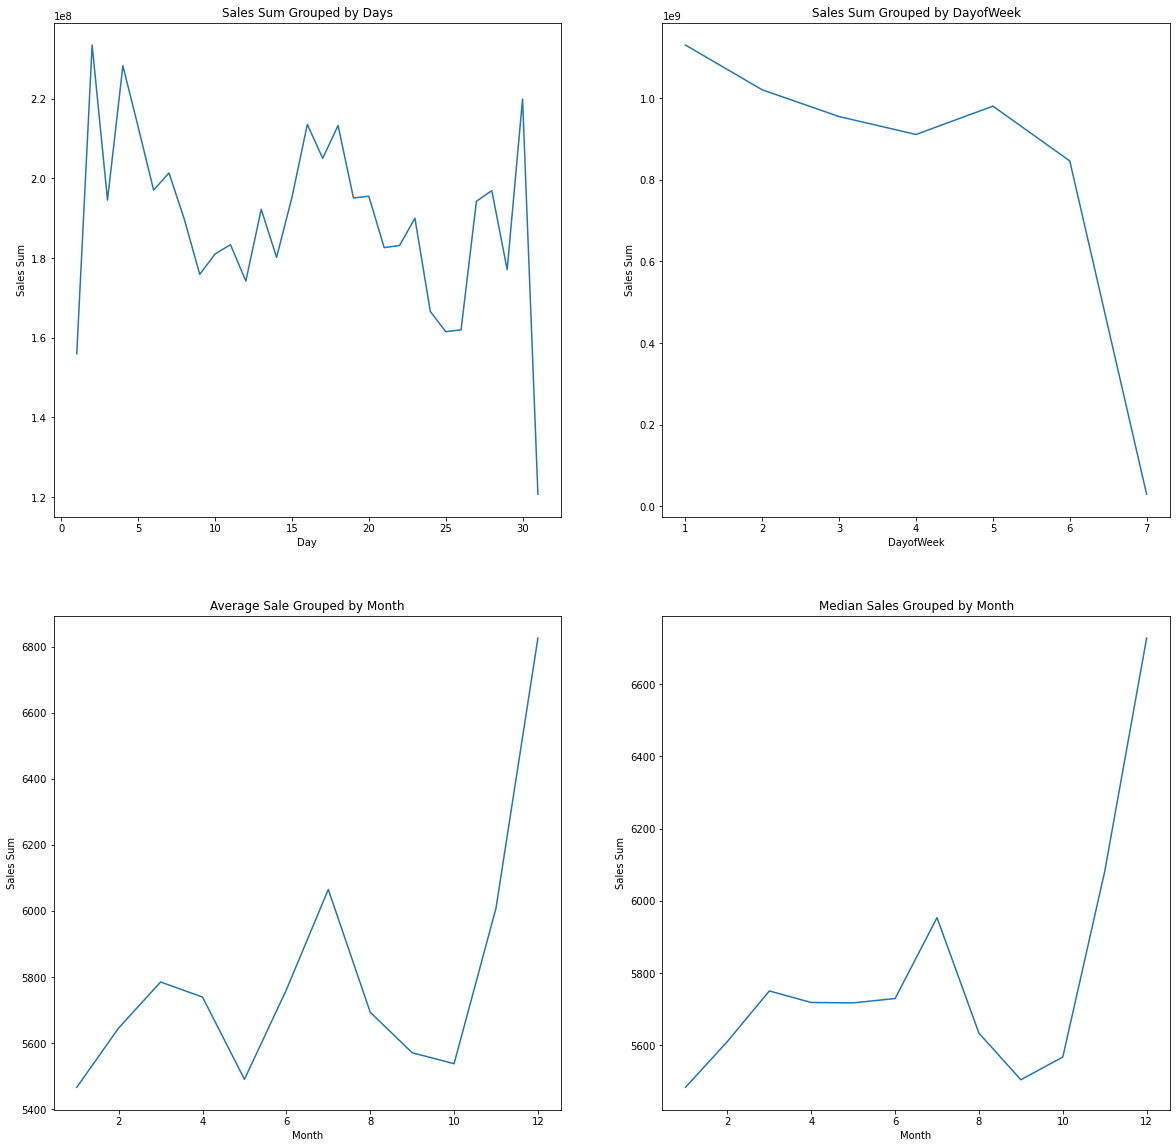

In [12]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,20))

axes[0,0].plot(df.groupby(df.Day).sum().Sales)
axes[0,0].set_title('Sales Sum Grouped by Days')
axes[0,0].set_xlabel('Day')
axes[0,0].set_ylabel('Sales Sum')


axes[0,1].plot(df.groupby(df.DayOfWeek).sum().Sales)
axes[0,1].set_title("Sales Sum Grouped by DayofWeek")
axes[0,1].set_xlabel('DayofWeek')
axes[0,1].set_ylabel('Sales Sum')


axes[1,0].plot(df.groupby(df.Month).mean().Sales)
axes[1,0].set_title("Average Sale Grouped by Month")
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Sales Sum')


axes[1,1].plot(df.groupby(df.Month).median().Sales)
axes[1,1].set_title("Median Sales Grouped by Month")
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Sales Sum')

plt.show()

### Sales Feature and Correlations

- Sales are highly correlated with `Customers` and `Open` 
- moderately correlated with `Promo`. 

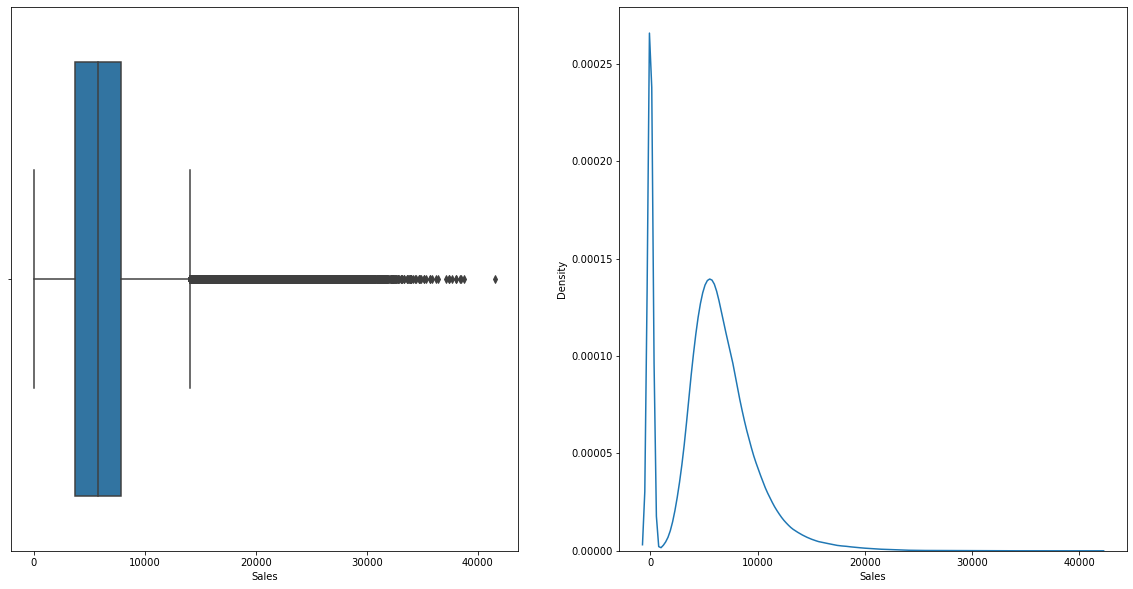

In [13]:
fig, axes =plt.subplots(nrows=1,ncols=2,figsize=(20,10))
sns.boxplot(train.Sales, ax=axes[0])
sns.kdeplot(train.Sales,ax=axes[1])
plt.show()

In [14]:
# Open - an indicator for whether the store was open: 0 = closed, 1 = open
df[df.Open==0].Sales.value_counts()
# 172817 close day

0    172817
Name: Sales, dtype: int64

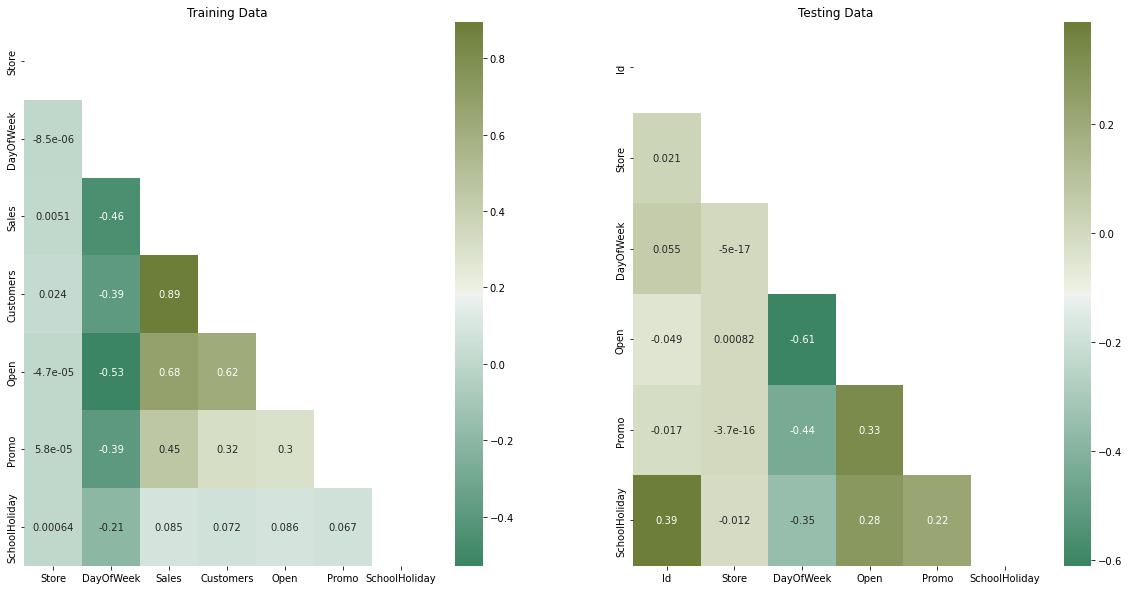

In [15]:
fig, axes=plt.subplots(nrows=1,ncols=2, figsize=(20,10))

cmap = sns.diverging_palette(150, 100, as_cmap=True)
corr=train.corr()
mask=np.triu(np.ones_like(corr,dtype=bool))
sns.heatmap(train.corr(),ax=axes[0],annot=True,mask=mask,cmap=cmap)
axes[0].set_title('Training Data')
corr=test.corr()
mask=np.triu(np.ones_like(corr,dtype=bool))
sns.heatmap(test.corr(),ax=axes[1],annot=True,mask=mask,cmap=cmap)
axes[1].set_title('Testing Data')
plt.show()

### Sales vs Customers #

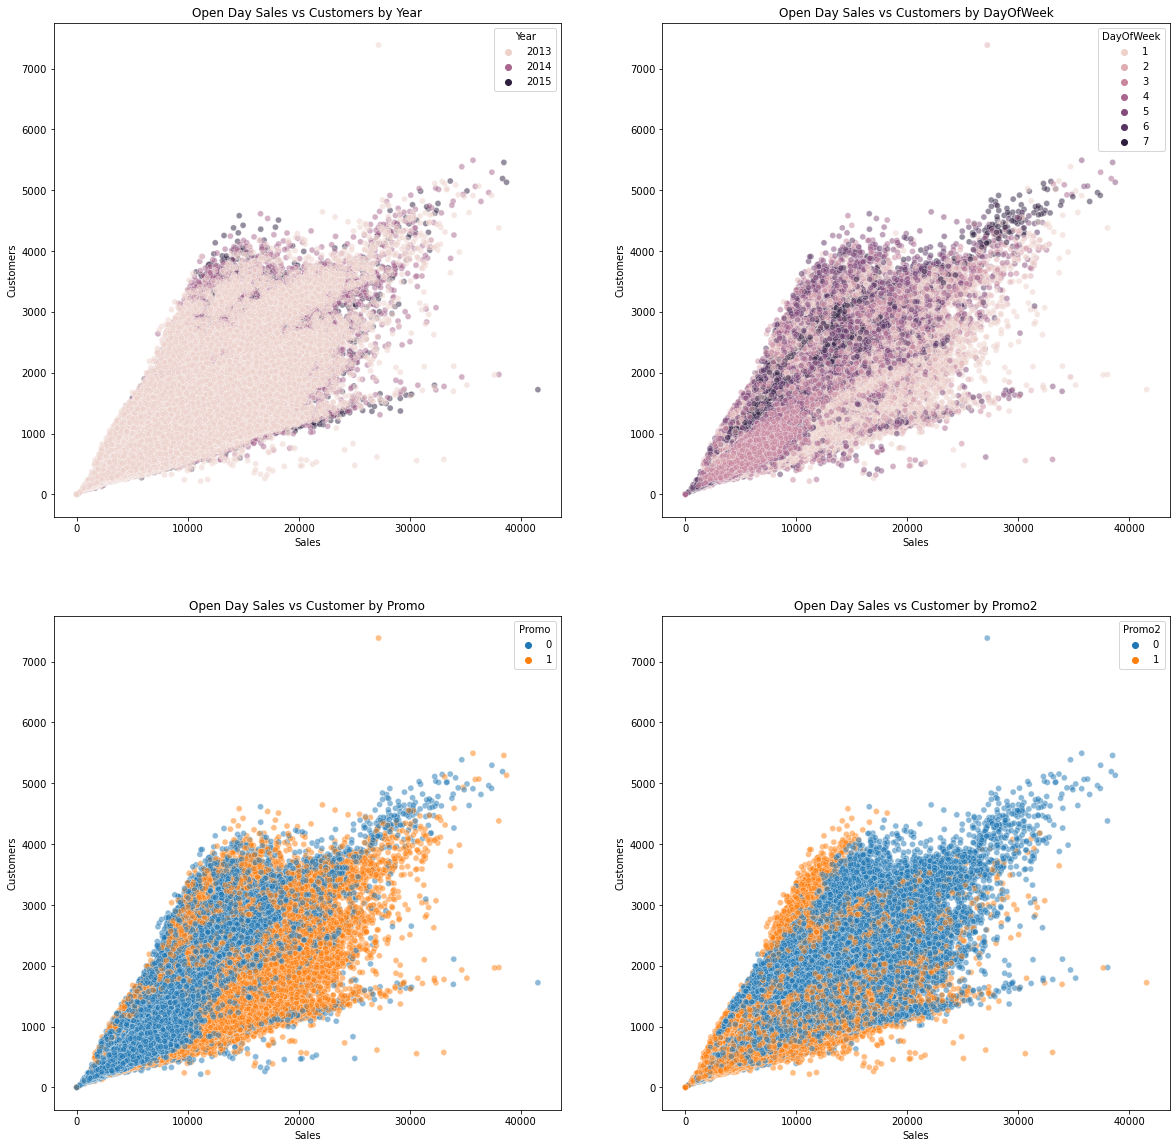

In [18]:
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(20,20))

df_open=df[df.Open==1]
sns.scatterplot(df_open.Sales,df_open.Customers, hue=df.Year, alpha=0.5, ax=axes[0,0])
axes[0,0].set_title("Open Day Sales vs Customers by Year")

sns.scatterplot(df_open.Sales,df_open.Customers, hue=df.DayOfWeek, alpha=0.5, ax=axes[0,1])
axes[0,1].set_title("Open Day Sales vs Customers by DayOfWeek")

sns.scatterplot(df_open.Sales, df_open.Customers, hue=df.Promo, alpha=0.5, ax=axes[1,0])
axes[1,0].set_title("Open Day Sales vs Customer by Promo")

sns.scatterplot(df_open.Sales, df_open.Customers, hue=df.Promo2, alpha=0.5, ax=axes[1,1])
axes[1,1].set_title("Open Day Sales vs Customer by Promo2")


plt.show()

### Store Type Feature

- Store Type Count: A>D>C>B 
- Store Avg competition distance: D>A>C>B
- Store average sales may relate to the distance of competition
    - Store B has the lowest average sales may due to nearest distance to competitors
- % Promo days were close among 4 stores

- Distance to nearest competitors may affect the average sales

In [20]:
df.StoreType.value_counts()

a    551627
d    312912
c    136840
b     15830
Name: StoreType, dtype: int64

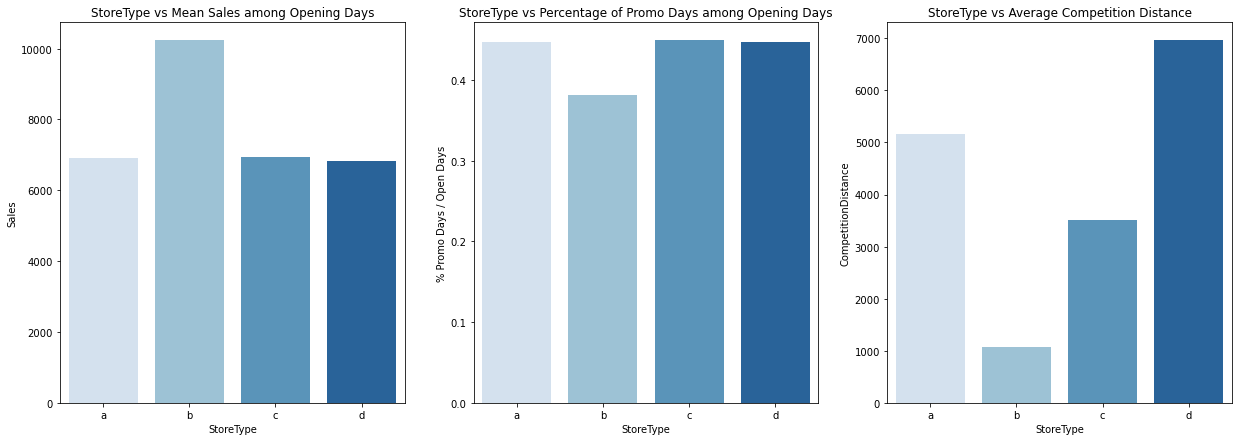

In [24]:
fig, axes = plt.subplots(1,3,figsize=(21,7))
df_store = df_open.groupby(df_open.StoreType).mean()
sns.barplot(df_store.index,df_store.Sales,ax=axes[0],palette='Blues')
axes[0].set_title("StoreType vs Mean Sales among Opening Days")

df_store = df_open.groupby(df.StoreType).sum()
df_store['promo%']=df_open['Promo'].groupby(df_open.StoreType).sum()/df_open['Promo'].groupby(df_open.StoreType).count()
sns.barplot(df_store.index, df_store['promo%'], ax=axes[1], palette='Blues')
axes[1].set_ylabel("% Promo Days / Open Days")
axes[1].set_title("StoreType vs Percentage of Promo Days among Opening Days")

df_store_avg = df.groupby(df.StoreType).mean()
sns.barplot(df_store_avg.index, df_store_avg['CompetitionDistance'], ax=axes[2], palette='Blues')
axes[2].set_title("StoreType vs Average Competition Distance")
plt.show()



### Sales Trend

- 2014 has peak in the beginning (may due to high promo2) and lowest in Oct (may due to close competitors), and 2015 is better than mean sales.



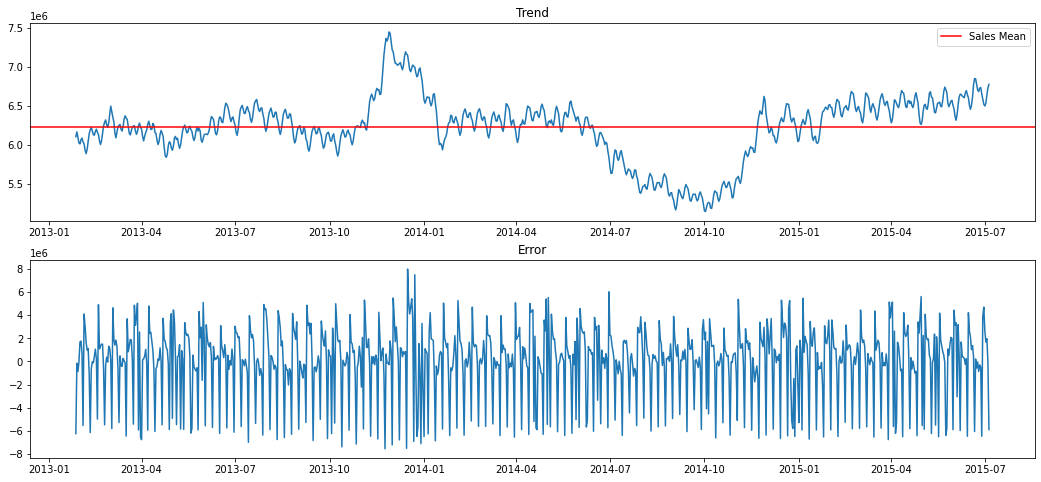

In [212]:
from statsmodels.tsa.seasonal import seasonal_decompose
temp_df = train.copy()
temp_df.Date = pd.to_datetime(temp_df.Date)
temp_df.index = temp_df.Date
temp_df = temp_df[['Sales']]
temp_df = temp_df.groupby(temp_df.index).sum()
result = seasonal_decompose(temp_df, model='additive', freq=52)


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,8))
axes[0].plot(result.trend)
axes[0].axhline(y = temp_df.Sales.mean(), color = 'r', linestyle = '-', label='Sales Mean')
axes[0].set_title("Trend")
axes[1].plot(result.resid)
axes[1].set_title("Error")
axes[0].legend()
plt.show()

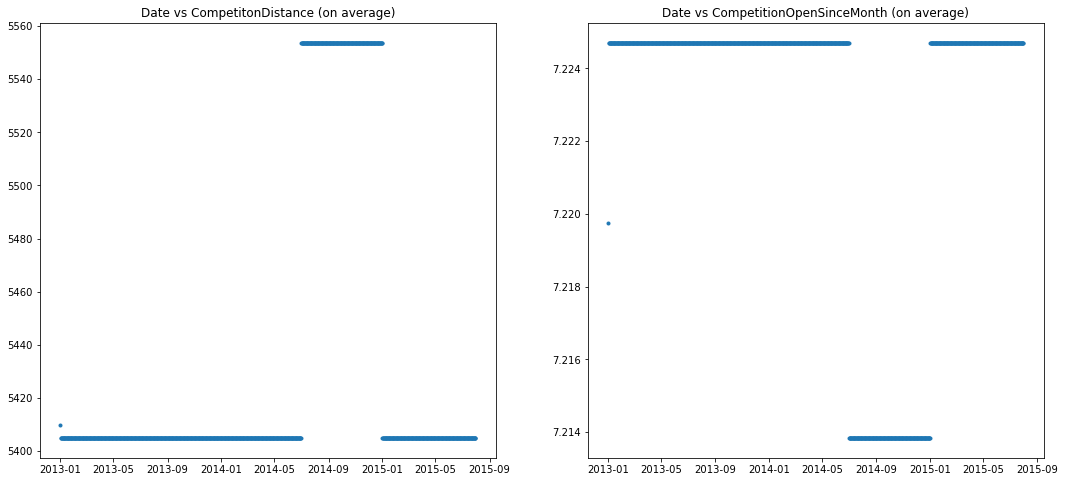

In [213]:
temp_df = df.copy()
temp_df.index = temp_df.Date
temp_df = temp_df.groupby(temp_df.index).mean()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax1.plot(temp_df.CompetitionDistance, '.')
ax1.set_title("Date vs CompetitonDistance (on average)")
ax2.plot(temp_df.CompetitionOpenSinceMonth, '.')
ax2.set_title("Date vs CompetitionOpenSinceMonth (on average)")
plt.show()

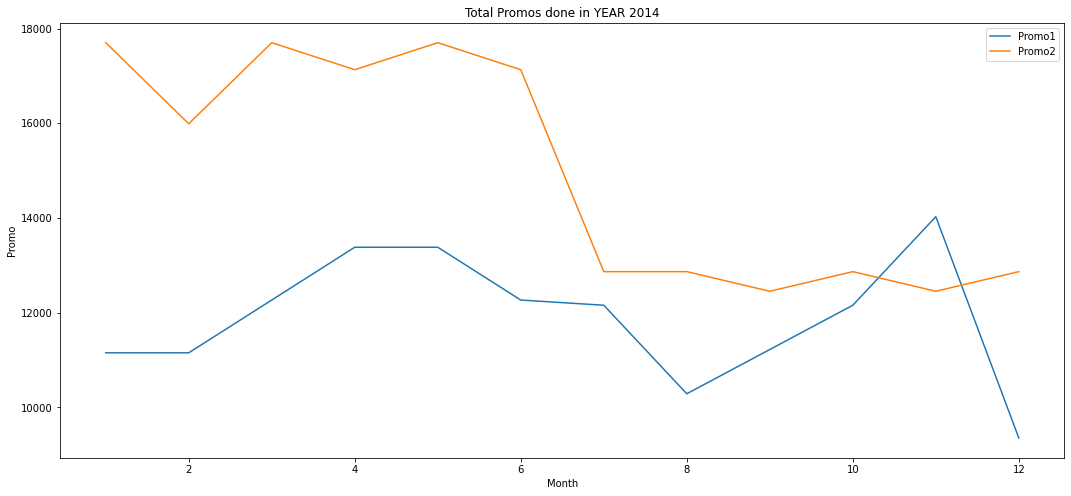

In [215]:
plt.figure(figsize=(18,8))
temp_df = df.copy()
temp_df.index = temp_df.Date
temp_df = temp_df[temp_df.Year==2014]
temp_df = temp_df.groupby(temp_df.Month).sum()

plt.title('Total Promos done in YEAR 2014')
sns.lineplot(temp_df.index, temp_df.Promo, palette='Blues', label='Promo1')
sns.lineplot(temp_df.index, temp_df.Promo2, palette='Blues', label='Promo2')
plt.legend()
plt.show()